In [1]:
# Frquent
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# ML
import sklearn
#import xgboost as xgb

#
from scipy.stats import skew

#
from sklearn.preprocessing import LabelBinarizer

In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class DFSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
class SkewTransform(BaseEstimator,TransformerMixin):
    def __init__(self,num_skew = True, cat_encode = True):
        self.num_skew = num_skew
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        skewed_feats = X.apply(lambda x: skew(x.dropna())) #compute skewness
        skewed_feats = skewed_feats[skewed_feats > 0.75]
        skewed_feats = skewed_feats.index
        X[skewed_feats] = np.log1p(X[skewed_feats])
        return X
class DFImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
class CateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #encoder = LabelBinarizer()
        #X = encoder.fit_transform(X)
        return pd.get_dummies(X)

In [66]:
y = np.log(train['SalePrice'])
X = train.drop(['SalePrice'],axis=1)
df = pd.concat([X, test])


In [46]:
num_attr = df.dtypes[train.dtypes != 'object'].index
cate_attr = df.dtypes[train.dtypes == 'object'].index

In [47]:
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
numpipe = Pipeline([
    ('selector',DFSelector(num_attr)),
    ('imputer',DFImputer()),
    ('trans',SkewTransform()),
    ('scaler',StandardScaler())
])
catepipe = Pipeline([
    ('selector',DFSelector(cate_attr)),
    ('imputer',DFImputer()),
    ('encode',CateEncoder())
    
])
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipe',numpipe),
    ('cat_pipe',catepipe)
])

In [48]:
df_trans=full_pipeline.fit_transform(df)

In [49]:
Xed = df_trans[:train.shape[0]]
test_trans = df_trans[train.shape[0]:]

In [74]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

model = Ridge()#ElasticNet()#RandomForestRegressor(n_estimators=100)#Ridge()

scores = cross_val_score(model,Xed, y, scoring='neg_mean_squared_error',cv=10 )
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print ('{0:f} ({1:f})').format(scores.mean(),scores.std())
display_scores(rmse_scores)

0.128259 (0.024940)


In [90]:
param_grid = [
    {'alpha':range(10,20)}
]
model = Ridge()
model = Ridge(alpha=14)
model.fit(Xed, y)
display_scores( rmse_cv(model))

0.126100 (0.015509)


In [116]:
param_grid = [
    {'alpha':[0.001,0.0015,0.002],'l1_ratio':[0.3,0.4,0.5]}
]
model = ElasticNet(alpha=0.001,l1_ratio=0.4)
model.fit(Xed, y)
display_scores( rmse_cv(model))

0.122800 (0.015804)


In [121]:
param_grid=[
    {'n_estimators':[350,400,450]}
]
model = RandomForestRegressor()#n_estimators=400)

In [122]:
grid_search = GridSearchCV(model, param_grid,cv=10,scoring='neg_mean_squared_error')
grid_search.fit(Xed, y)
print grid_search.best_params_
cvres= grid_search.cv_results_
for meantestscore, params in zip(cvres['mean_test_score'],cvres['params']):
    print (np.sqrt(-meantestscore), params)

{'n_estimators': 450}
(0.14105550909902653, {'n_estimators': 350})
(0.14106425421938748, {'n_estimators': 400})
(0.14090838717177212, {'n_estimators': 450})


ValueError: zero-size array to reduction operation minimum which has no identity

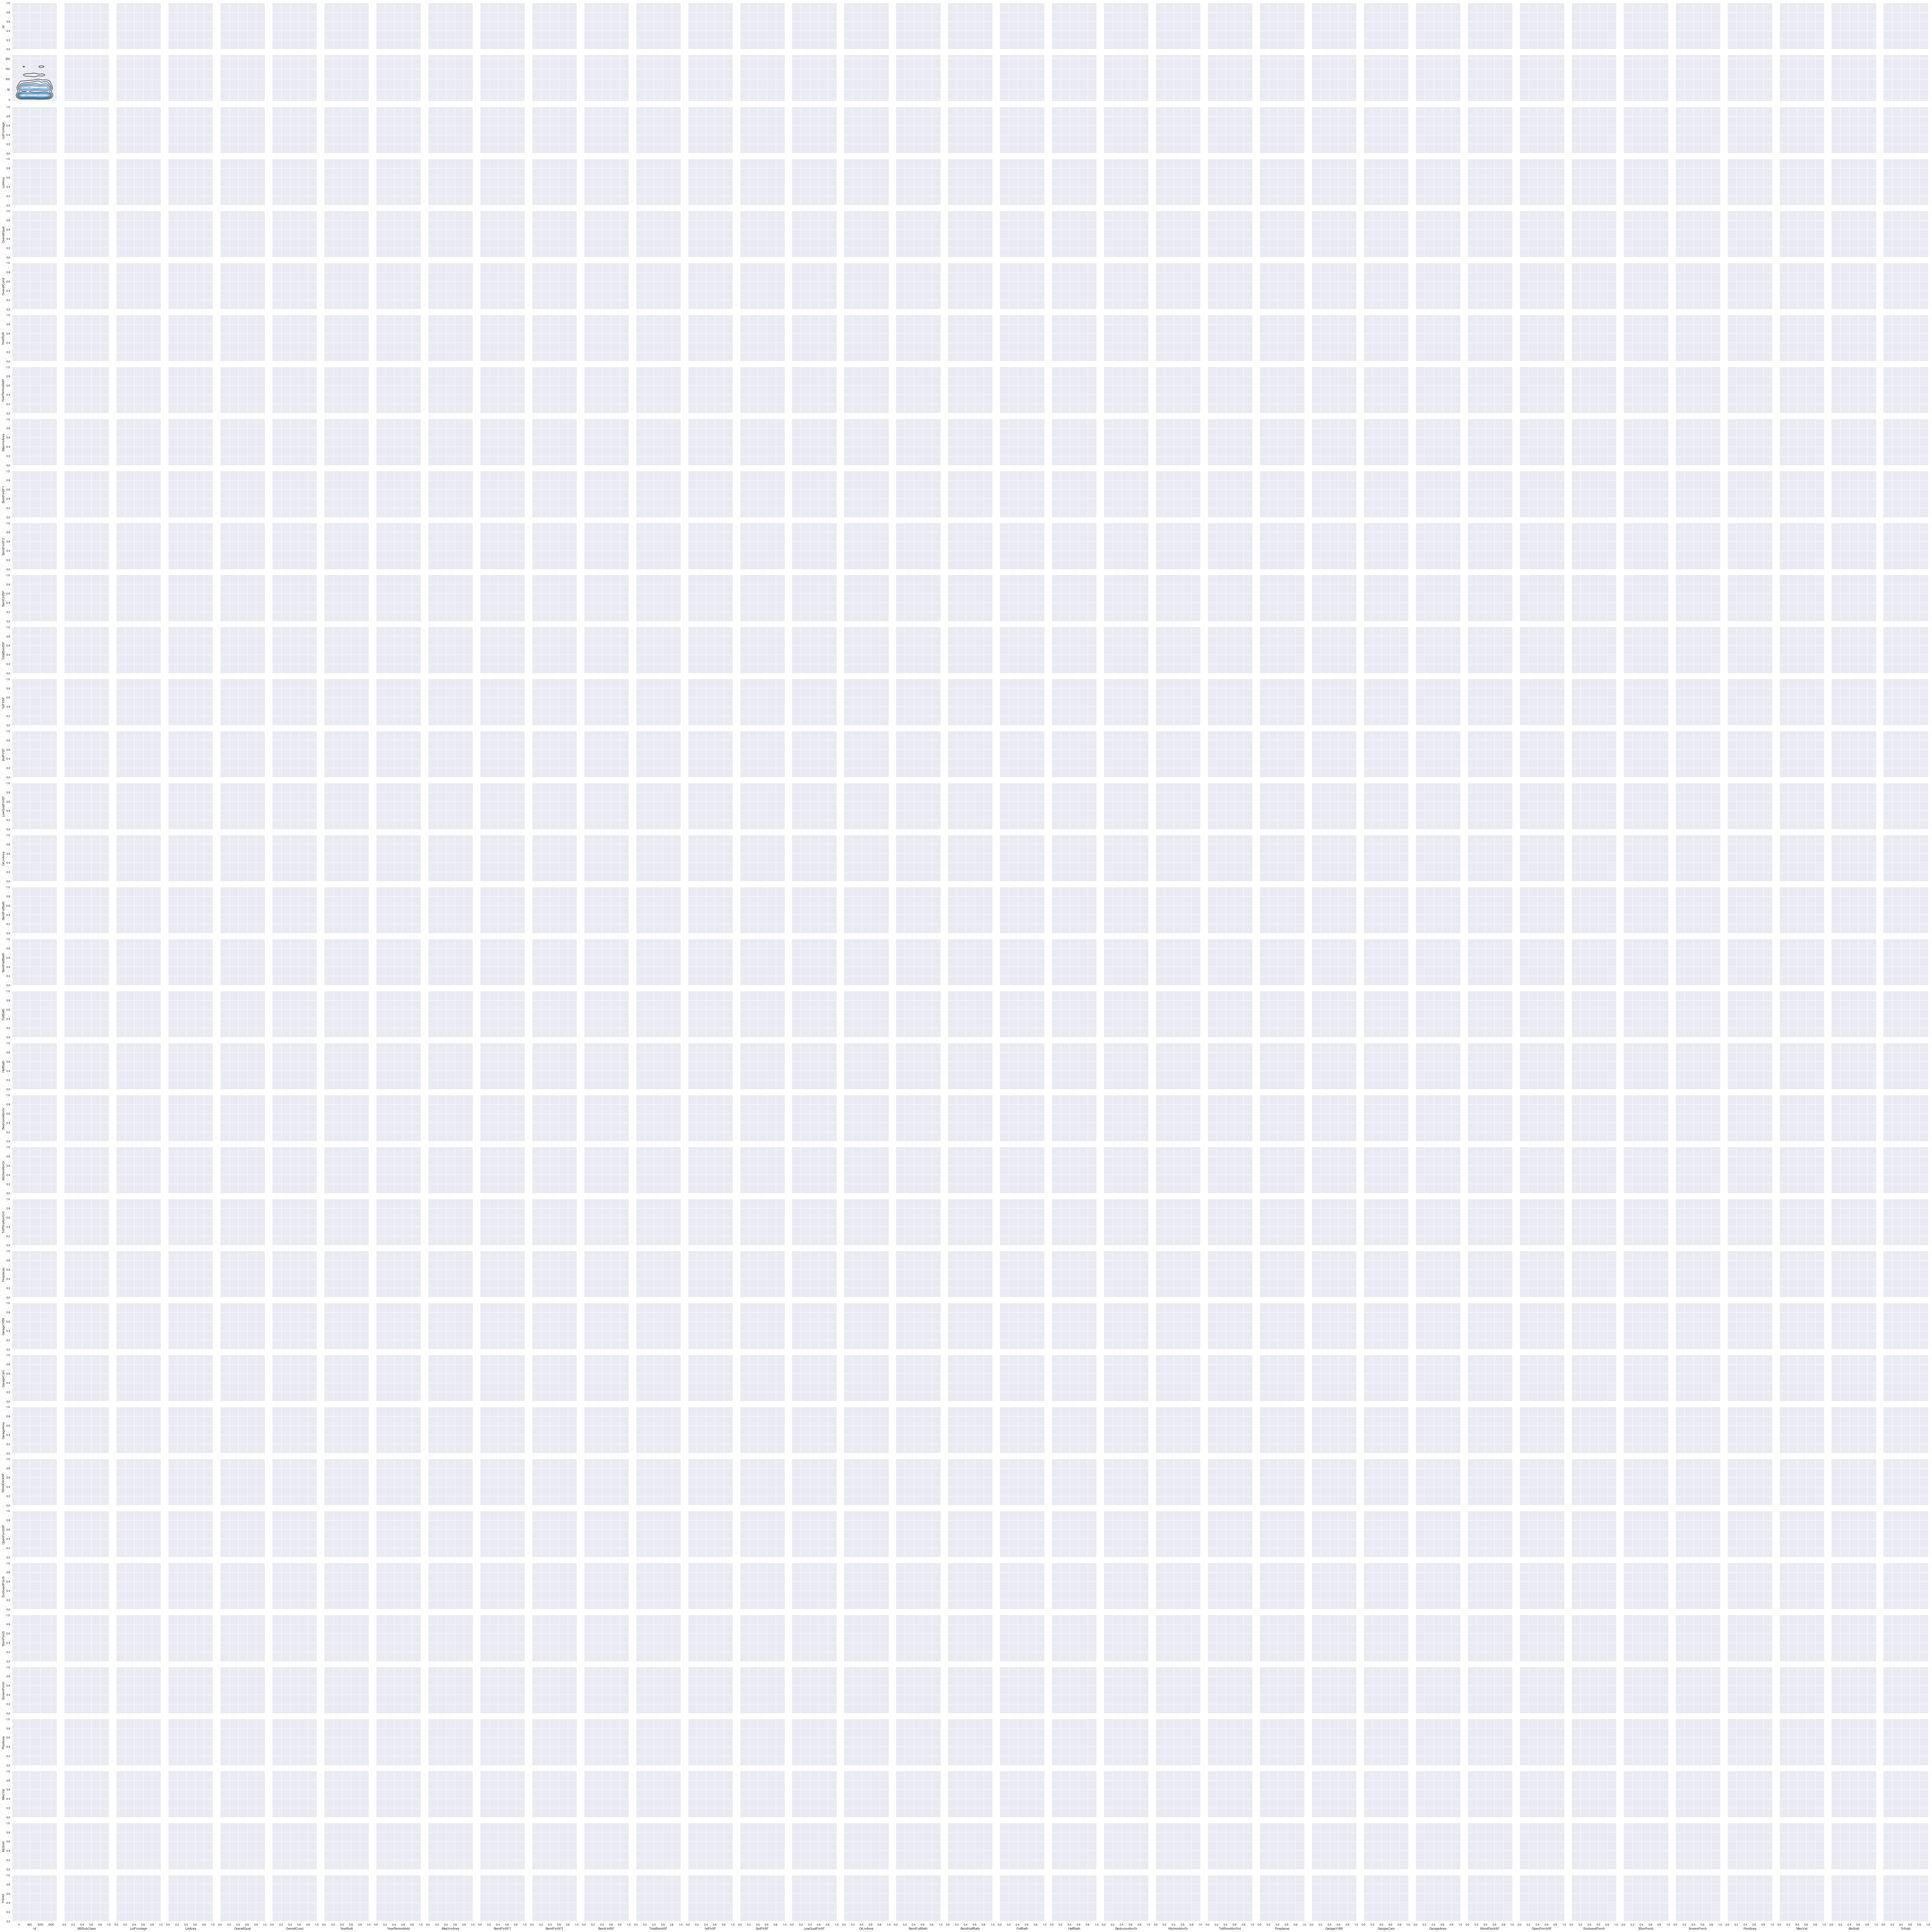

In [123]:
df = train[num_attr]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)


In [51]:
from sklearn.metrics import mean_squared_error
reg_Ridge.fit(Xed, y)
pred = reg_Ridge.predict(test_trans)
pred[:10]

array([ 109744.93183845,  155730.35852477,  185040.5002286 ,
        195442.65659276,  211843.11935047,  164891.40758347,
        170080.66049883,  158673.73678702,  206217.65302511,
        110137.63458913])